In [1]:
from gnews import GNews
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
import nltk
from sumy.summarizers.lsa import LsaSummarizer

import pandas as pd
import numpy as np
from tqdm import tqdm

/Users/alexbadin/miniconda3/envs/scraping/lib/python3.12/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.17) or chardet (5.2.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


## Load news

In [ ]:
# download news day by day (due to 100 limit) via combining dictionaries
start_date = '2023-08-01'
end_date = '2023-10-10'

rus_econ_news = []
for date in tqdm(pd.date_range(start_date, end_date)):
    google_news = GNews(language='ru', country='RU', start_date=date - pd.Timedelta(days=1), end_date=date)
    rus_econ_news += google_news.get_news('Экономика России')

100%|██████████| 71/71 [39:42<00:00, 33.55s/it]  


In [ ]:
pd.DataFrame(rus_econ_news).shape

(5613, 5)

In [ ]:
pd.DataFrame(rus_econ_news)['published date'].min(), pd.DataFrame(rus_econ_news)['published date'].max()

('Fri, 01 Sep 2023 07:00:00 GMT', 'Wed, 30 Aug 2023 13:07:37 GMT')

In [ ]:
# iterate over the news
for news in tqdm(rus_econ_news):
    try:
        # get the full article
        news['full_article'] = google_news.get_full_article(news['url']).text
    except:
        news['full_article'] = ''

100%|██████████| 5613/5613 [2:27:55<00:00,  1.58s/it]


### summarization

In [ ]:
summarizer_2 = LsaSummarizer()
nltk.download('punkt')

def summarize(text, language="english", sentences_count=5):
    parser = PlaintextParser.from_string(text, Tokenizer(language))
    summarizer = LsaSummarizer()
    summary = summarizer(parser.document, sentences_count)
    return ' '.join([str(sentence) for sentence in summary])

[nltk_data] Downloading package punkt to /Users/alexbadin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# summarize the news
for news in tqdm(rus_econ_news):
    try:
        news['summary'] = summarize(news['full_article'], language="russian", sentences_count=2)
    except:
        news['summary'] = ''

100%|██████████| 5613/5613 [01:52<00:00, 49.82it/s] 


In [ ]:
df_news = pd.DataFrame(rus_econ_news)
df_news.head(2)

,title,description,published date,url,publisher,full_article,summary
0,Экономика России: финансист Станислав Краснояр...,Экономика России: финансист Станислав Краснояр...,"Tue, 01 Aug 2023 07:00:00 GMT",https://news.google.com/rss/articles/CBMiOGh0d...,"{'href': 'https://www.chita.ru', 'title': 'Чит...",,
1,Дело спроса: российская экономика пошла в рост...,Дело спроса: российская экономика пошла в рост...,"Mon, 31 Jul 2023 07:00:00 GMT",https://news.google.com/rss/articles/CBMiVmh0d...,"{'href': 'https://eadaily.com', 'title': 'EADa...",Российская экономика во втором квартале 2023 г...,Российская экономика во втором квартале 2023 г...


In [ ]:
(df_news['summary']=='').sum(), (df_news['summary']!='').sum()

(613, 5000)

In [ ]:
df_news.to_csv('rus_econ_news.csv', index=False)

In [ ]:
df_news = pd.read_csv('rus_econ_news.csv')

In [ ]:
# fill the missing articles with the description (from Google News)
df_news['full_article'].fillna(df_news['description'], inplace=True)
df_news['summary'].fillna(df_news['description'], inplace=True)

<Axes: ylabel='Frequency'>

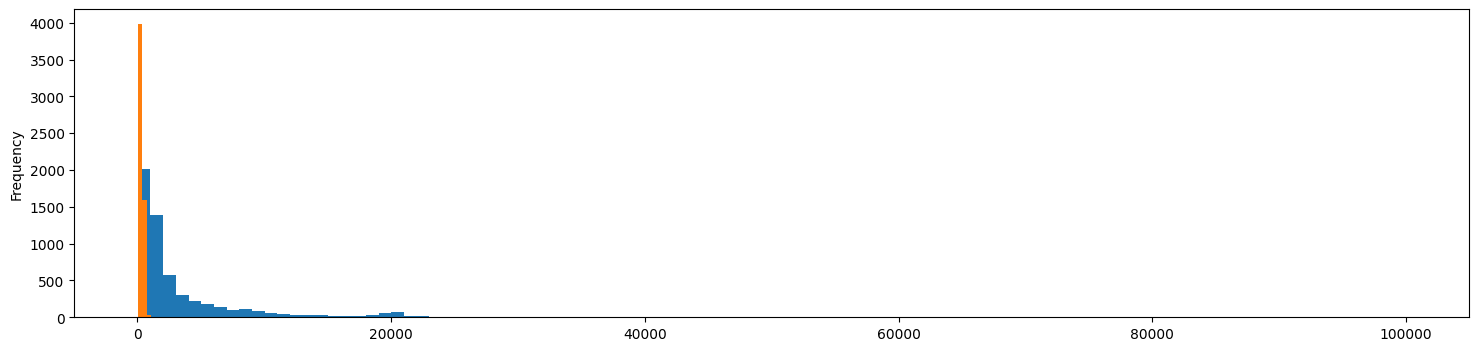

In [ ]:
# compare the length of the full article and summary on separate histograms
df_news['full_article'].str.len().plot.hist(bins=100, figsize=(18, 4))
df_news['summary'].str.len().plot.hist(bins=30)

In [ ]:
pd.DataFrame([df_news['full_article'].str.len().describe(), df_news['summary'].str.len().describe()])

,count,mean,std,min,25%,50%,75%,max
full_article,5613.0,3621.956886,6288.256807,31.0,692.0,1490.0,3778.0,100000.0
summary,5613.0,319.579904,197.574501,31.0,236.0,319.0,400.0,10676.0


In [ ]:
# convert to date (YY-MM-DD) format
df_news['date'] = pd.to_datetime(df_news['published date']).dt.date
# min and max dates
df_news['date'].min(), df_news['date'].max()

(datetime.date(2023, 7, 31), datetime.date(2023, 10, 10))

# Important news identification

- create embeddings for all texts
- prepare datasets - important(selected by Kulbaka) & unimportant news (all news minus important)
- create model

In [ ]:
df_news = pd.read_csv('rus_econ_news.csv')

In [ ]:
df_news.shape

(5613, 8)

In [ ]:
df_news.loc[5,'publisher']

"{'href': 'https://www.ng.ru', 'title': 'Независимая газета'}"

### load important news & summarise

In [ ]:
df_import_news = pd.read_csv('important_news.csv', sep=';')

In [ ]:
summarizer_2 = LsaSummarizer()
nltk.download('punkt')

def summarize(text, language="english", sentences_count=5):
    parser = PlaintextParser.from_string(text, Tokenizer(language))
    summarizer = LsaSummarizer()
    summary = summarizer(parser.document, sentences_count)
    return ' '.join([str(sentence) for sentence in summary])

[nltk_data] Downloading package punkt to /Users/alexbadin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
df_import_news['summary'] = df_import_news['Новость'].apply(lambda x: summarize(x, language="russian", sentences_count=2))

### create text dataset

First, filter out important news from main dataset

In [ ]:
# find all news from df_import_news in df_news
df_news['important_news'] = 0
for news_text in tqdm(df_import_news['Новость']):
    df_news.loc[df_news['full_article'].str.contains(str(news_text.split('. ')[0])), 'important_news'] = 1

print('Number of important news:', df_news.important_news.sum())

  0%|          | 0/110 [00:00<?, ?it/s]

/var/folders/2f/4wrcxd5n7_zbgfnwpf77l3bm0000gn/T/ipykernel_89777/2983162485.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_news.loc[df_news['full_article'].str.contains(str(news_text.split('. ')[0])), 'important_news'] = 1
100%|██████████| 110/110 [00:02<00:00, 52.25it/s]

Number of important news: 98


In [ ]:
# dataset of texts of important and not important news with labels
texts_labels_1 = pd.DataFrame()
texts_labels_0 = pd.DataFrame()

texts_labels_1['text'] = df_import_news['summary']
texts_labels_1['label'] = 1
# take only non-important news from df_news
texts_labels_0['text'] = df_news.loc[df_news['important_news']==0, 'summary']
texts_labels_0['label'] = 0

# combine the datasets with labels
texts_labels = pd.concat([texts_labels_1, texts_labels_0])

In [ ]:
texts_labels['len'] = texts_labels['text'].str.len()
# compare the length by label
texts_labels.groupby('label')['len'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,5515.0,318.160471,198.386964,31.0,234.5,318.0,399.00,10676.0
1,110.0,260.472727,79.933884,87.0,211.0,249.5,317.75,530.0


Distribution of length mostly within similar range.

Dataset is very inbalanced, but we'll deal with it later. First, create embeds for all texts.

In [ ]:
texts_labels.label.value_counts()

label
0    5515
1     110
Name: count, dtype: int64

In [ ]:
texts_labels.to_csv('texts_labels.csv', index=False)

### Create embeddings

This section is performed in Colab to leverage T4 and save local disk space on model

In [5]:
!pip install --quiet sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 77.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 40.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 93.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 91.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 39.4 MB/s eta 0:00:00


In [6]:
import pandas as pd
import numpy as np
from tqdm import tqdm

from sentence_transformers import SentenceTransformer
model = SentenceTransformer('intfloat/multilingual-e5-large')

In [7]:
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/Colab Notebooks/other/econ_news(Kulbaka)/'

Mounted at /content/drive


In [8]:
texts_labels = pd.read_csv(path+'texts_labels.csv')

In [9]:
texts = texts_labels['text'].to_list()
embeddings = model.encode(texts, show_progress_bar=True)
texts_labels["emb_e5"] = [row.reshape(-1) for row in embeddings]

Batches:   0%|          | 0/176 [00:00<?, ?it/s]

In [10]:
np.save(path+"texts_embddings.npy", embeddings)

In [11]:
texts_labels.to_csv(path+'texts_labels_emb.csv')

# Class-n model

In [2]:
texts_labels = pd.read_csv('texts_labels.csv')

In [3]:
embeds = np.load('texts_embddings.npy')
embeds.shape

(5625, 1024)

In [4]:
texts_labels.groupby('label')['len'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,5515.0,318.160471,198.386964,31.0,234.5,318.0,399.00,10676.0
1,110.0,260.472727,79.933884,87.0,211.0,249.5,317.75,530.0


In [5]:
# join the embeddings with the labels
texts_labels_emb = pd.DataFrame(embeds)
texts_labels_emb['label'] = texts_labels['label']
texts_labels_emb['text'] = texts_labels['text']

In [20]:
# rebalance the dataset
sample_1 = texts_labels_emb[texts_labels_emb['label']==1].sample(300, random_state=42, replace=True)
sample_0 = texts_labels_emb[texts_labels_emb['label']==0].sample(900)
sample = pd.concat([sample_1, sample_0])

After first model: find important news via model & add them to sample

In [21]:
# split the dataset into train and test
from sklearn.model_selection import train_test_split

y = sample['label']
X = sample.drop(['label', 'text'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# check shapes
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((960, 1024), (240, 1024), (960,), (240,))

In [22]:
# train regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

clf = LogisticRegression(random_state=42).fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.99      0.92       178
           1       0.97      0.50      0.66        62

    accuracy                           0.87       240
   macro avg       0.91      0.75      0.79       240
weighted avg       0.88      0.87      0.85       240



In [23]:
y_prob = clf.predict_proba(X_test)[:,1]

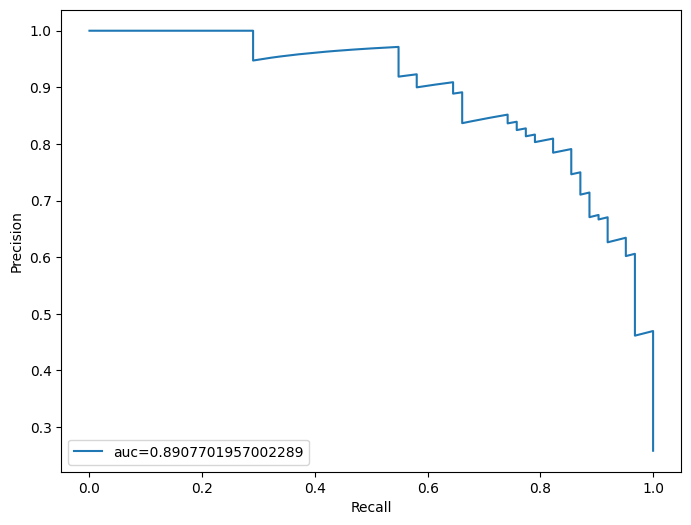

In [24]:
# precision-recall auc
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(y_test, y_prob)
auc_score = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='auc='+str(auc_score))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left');

In [33]:
import plotly.express as px

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

fig = px.line(x=recall, y=precision, title='Precision-Recall Curve')
fig.add_scatter(x=recall, y=precision, mode='markers', text=[f'threshold={t:.2f}' for t in thresholds])

fig.update_layout(
    xaxis_title='Recall',
    yaxis_title='Precision',
    width=800,
    height=600,
)

fig.show()


При prob≥0.38 начинается сильное падение precision, при этом recall растет мало.

Идеальный уровень(threshold) = 0.37-0.39. 

In [66]:
# save the model
import pickle

with open('news_importance_model.pkl', 'wb') as f:
    pickle.dump(clf, f)

In [64]:
# reveal texts of news which are predicted as important
texts_labels_emb['pred'] = clf.predict(texts_labels_emb.iloc[:,:1024])
texts_labels_emb['prob'] = clf.predict_proba(texts_labels_emb.iloc[:,:1024])[:,1]

In [36]:
texts_classified = texts_labels_emb.iloc[:,-3:]
# share of important news
print(f'Share of important news: {round(texts_classified['pred'].mean(), 4)*100}%, or {texts_classified['pred'].sum()} news of {texts_classified.shape[0]}')

Share of important news: 1.8499999999999999%, or 104 news of 5625


In [37]:
# add true labels
texts_classified['true_label'] = texts_labels['label']

# compare the true and predicted labels via crosstab
pd.crosstab(texts_classified['true_label'], texts_classified['pred'] )

pred,0,1
true_label,,
0,5451,64
1,70,40


In [38]:
# same cross-tab, but with probabilities
pd.crosstab(texts_classified['true_label'], texts_classified['pred'], values=texts_classified['prob'], aggfunc='mean')

pred,0,1
true_label,,
0,0.174969,0.579585
1,0.376078,0.610262


In [39]:
texts_classified

,text,pred,prob,true_label
0,5 октября Всемирный банк (ВБ) вновь улучшил пр...,1,0.726296,1
1,Запрет на экспорт топлива из России сохраняетс...,1,0.583643,1
2,«Подсушивание» предложения топлива помогло выв...,0,0.454453,1
3,Цены на поездки в такси за сентябрь выросли от...,1,0.531292,1
4,6 октября. INTERFAX.RU - Российский рубль заме...,0,0.438723,1
...,...,...,...,...
5620,Для клиента и перевозчика предлагается ввести ...,0,0.130054,0
5621,"Я могу сказать, что мы на следующую трехлетку ...",0,0.301428,0
5622,По субботам собираем для вас все самое важное ...,0,0.125334,0
5623,"А также предупреждает о том, что дача взятки д...",0,0.123818,0


In [45]:
# load important news
df_import_news = pd.read_csv('important_news.csv', sep=';')
df_import_news.shape

(110, 6)

In [50]:
df_import_news['Новость']

0      5 октября Всемирный банк (ВБ) вновь улучшил пр...
1      Сохранение принципов «экспортного паритета» и ...
2      Участники соглашения ОПЕК+ подтвердили уровень...
3      Цены на поездки в такси за сентябрь выросли от...
4      6 октября. INTERFAX.RU - Российский рубль заме...
                             ...                        
105    Чтобы обеспечить национальную безопасность, ну...
106    Рынок акций РФ во вторник продолжил рост на фо...
107    В России будет создан специальный правовой реж...
108    Восстановление автомобильной отрасли отличаетс...
109    Россия вводит запрет на импорт из недружествен...
Name: Новость, Length: 110, dtype: object

In [56]:
df_import_news['prob'] = texts_classified['prob']
df_import_news['pred'] = texts_classified['pred']

In [55]:
# chart prob vs важность
import plotly.express as px

fig = px.scatter(df_import_news, x="важность", y="prob", hover_data=['Новость'])
fig.update_traces(marker=dict(size=12,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

In [65]:
# correlation between prob and важность
df_import_news[['важность', 'prob']].corr()

,важность,prob
важность,1.000000,0.264282
prob,0.264282,1.000000


Very poor correlation between level of importance & probability - but the model was not trained for level. 

In [62]:
(df_import_news['prob'] > .38).sum()

83

# INFERENCE
- load news
- select important ones (via model)
- check positive / negative

## Load news (incl full texts)

In [ ]:
from gnews import GNews
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
import nltk
from sumy.summarizers.lsa import LsaSummarizer

import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm

/Users/alexbadin/miniconda3/envs/scraping/lib/python3.12/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.17) or chardet (5.2.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [68]:
# set today's date
# date = pd.to_datetime('today').date()

# google_news = GNews(language='ru', country='RU', start_date=date - pd.Timedelta(days=1), end_date=date)
# today_news = google_news.get_news('Экономика России')

In [ ]:
# download news day by day (due to 100 limit) via combining dictionaries
start_date = '2023-10-03'
end_date = '2023-10-10'

rus_econ_news = []
for date in tqdm(pd.date_range(start_date, end_date)):
    google_news = GNews(language='ru', country='RU', start_date=date - pd.Timedelta(days=1), end_date=date)
    rus_econ_news += google_news.get_news('Экономика России')

100%|██████████| 71/71 [39:42<00:00, 33.55s/it]  


In [70]:
# iterate over the news
for news in tqdm(rus_econ_news):
    try:
        # get the full article
        news['full_article'] = google_news.get_full_article(news['url']).text
    except:
        news['full_article'] = ''

  0%|          | 0/89 [00:00<?, ?it/s]

100%|██████████| 89/89 [02:18<00:00,  1.55s/it]


In [73]:
summarizer_2 = LsaSummarizer()
nltk.download('punkt')

def summarize(text, language="english", sentences_count=5):
    parser = PlaintextParser.from_string(text, Tokenizer(language))
    summarizer = LsaSummarizer()
    summary = summarizer(parser.document, sentences_count)
    return ' '.join([str(sentence) for sentence in summary])

[nltk_data] Downloading package punkt to /Users/alexbadin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [74]:
# summarize the news (select 2 most important sentences)
for news in tqdm(rus_econ_news):
    try:
        news['summary'] = summarize(news['full_article'], language="russian", sentences_count=2)
    except:
        news['summary'] = ''

100%|██████████| 89/89 [00:05<00:00, 17.76it/s]


In [77]:
today_news = pd.DataFrame(rus_econ_news)
# replace missing articles with descriptions
today_news['full_article'].fillna(today_news['description'], inplace=True)
today_news['summary'].fillna(today_news['description'], inplace=True)

## Select important news
- embeddings
- predict importance

In [79]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('intfloat/multilingual-e5-large')

ModuleNotFoundError: No module named 'sentence_transformers'

In [ ]:
# embed the news
texts = today_news['summary'].to_list()
embeddings = model.encode(texts, show_progress_bar=True)

texts_labels["emb_e5"] = [row.reshape(-1) for row in embeddings]

In [1]:
last_news

NameError: name 'last_news' is not defined

In [ ]:
candidate_labels = ["позитив для российской экономики", "негатив для российской экономики"]

for i, row in tqdm(last_news[last_news.important==1].iterrows(), total = last_news[last_news.important==1].shape[0]):
    output = classifier(row['summary'], candidate_labels, multi_label=False)
    last_news.at[i, 'positive_prob'] = output['scores'][0]
    last_news.at[i, 'negative_prob'] = output['scores'][1]

In [ ]:
bad_news = ['плохо для российской экономики', 'российская экономика ухудшается', 'негативная новость для экономики России']
good_news = ['хорошо для российской экономики', 'российская экономика  улучшается', 'позитивная новость для экономики России']
candidate_labels = bad_news + good_news
n_labels = len(candidate_labels)

for i, row in tqdm(last_imp_news.iterrows(), total = last_news[last_news.important==1].shape[0]):
        output = classifier(row['summary'], candidate_labels, multi_label=True)
        for i in range(n_labels):            last_imp_news.at[i, output['labels'][i]] = output['scores'][i]



In [ ]:
# average bad and good news
last_imp_news['bad_news'] = last_imp_news[bad_news].mean(axis=1)